# Сравнение классических методов анализа АБ-тестов с квази-эксперименами
И проверка того, как хорошо пишет код ChatGPT o1-preview

### Версия промпта 1

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


# Set random seed for reproducibility
np.random.seed(42)

# Generate date range
date_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
n = len(date_range)  # Number of days

# Number of units (e.g., stores, users)
num_units = 100

# Initialize DataFrame
data = pd.DataFrame({
    'date': np.tile(date_range, num_units),
    'unit': np.repeat(np.arange(num_units), n)
})

# Generate trend component
trend = np.linspace(0, 10, n)

# Generate seasonal component (weekly seasonality)
seasonality = 5 * np.sin(2 * np.pi * data['date'].dt.dayofyear / 7)

# Generate random noise
noise = np.random.normal(0, 1, n * num_units)

# Generate unit-level random effects
unit_effect = np.random.normal(0, 2, num_units)
data['unit_effect'] = data['unit'].map(dict(zip(np.arange(num_units), unit_effect)))

# Combine components to create the metric
data['metric'] = (
    trend[data['date'].dt.dayofyear - 1] +
    seasonality +
    data['unit_effect'] +
    noise
)

# Remove unnecessary columns
data = data[['date', 'unit', 'metric']]

# Preview the data
print(data.head())


        date  unit    metric
0 2022-01-01     0  6.997119
1 2022-01-02     0  7.355095
2 2022-01-03     0  5.463300
3 2022-01-04     0  2.027276
4 2022-01-05     0 -2.407655


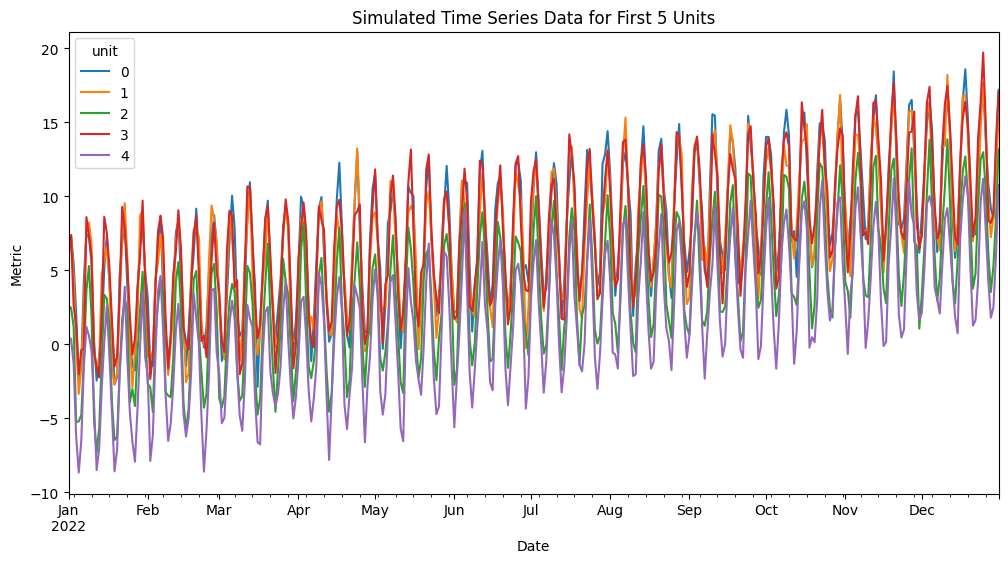

In [ ]:
# Pivot data for plotting
pivot_df = data.pivot(index='date', columns='unit', values='metric')

# Plot time series for the first 5 units
pivot_df.iloc[:, :5].plot(figsize=(12, 6))
plt.title('Simulated Time Series Data for First 5 Units')
plt.xlabel('Date')
plt.ylabel('Metric')
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Function to perform a single AA test
def perform_aa_test(data, control_units, test_units):
    data['group'] = data['unit'].apply(
        lambda x: 'control' if x in control_units else 'test'
    )
    grouped = data.groupby(['date', 'group'])['metric'].mean().reset_index()
    grouped_pivot = grouped.pivot(index='date', columns='group', values='metric')
    control_metric = grouped_pivot['control']
    test_metric = grouped_pivot['test']
    # Perform t-test
    t_stat, p_value = ttest_ind(control_metric, test_metric)
    return p_value

# Simulate multiple AA tests to estimate False Positive Rate
num_simulations = 1000
alpha = 0.05
false_positives = 0

for _ in range(num_simulations):
    # Randomly assign units to control and test groups
    units = np.arange(num_units)
    np.random.shuffle(units)
    control_units = units[:num_units // 2]
    test_units = units[num_units // 2:]

    p_value = perform_aa_test(data.copy(), control_units, test_units)
    if p_value < alpha:
        false_positives += 1

print(f"False Positive Rate (t-test): {false_positives / num_simulations:.4f}")


False Positive Rate (t-test): 0.1080


В промпте я просил сгенерировать time-series данные, что и получил. При этом модель некорректно применила t-test, и FPR больше заданного нами. Понятно, что так происзодит из-за зависимости между днями и нарушением предположения о независимости данных. В коде модель агграгирует по дням, хотя для корректности нам нужны пользователи. Такая картина кстати характерна, например, для офлайн ритейла, где есть магазины и их продажи за каждый день.

Я спросил, из-за чего происходит рост FPR и вот так отображается суммарзация процесса:

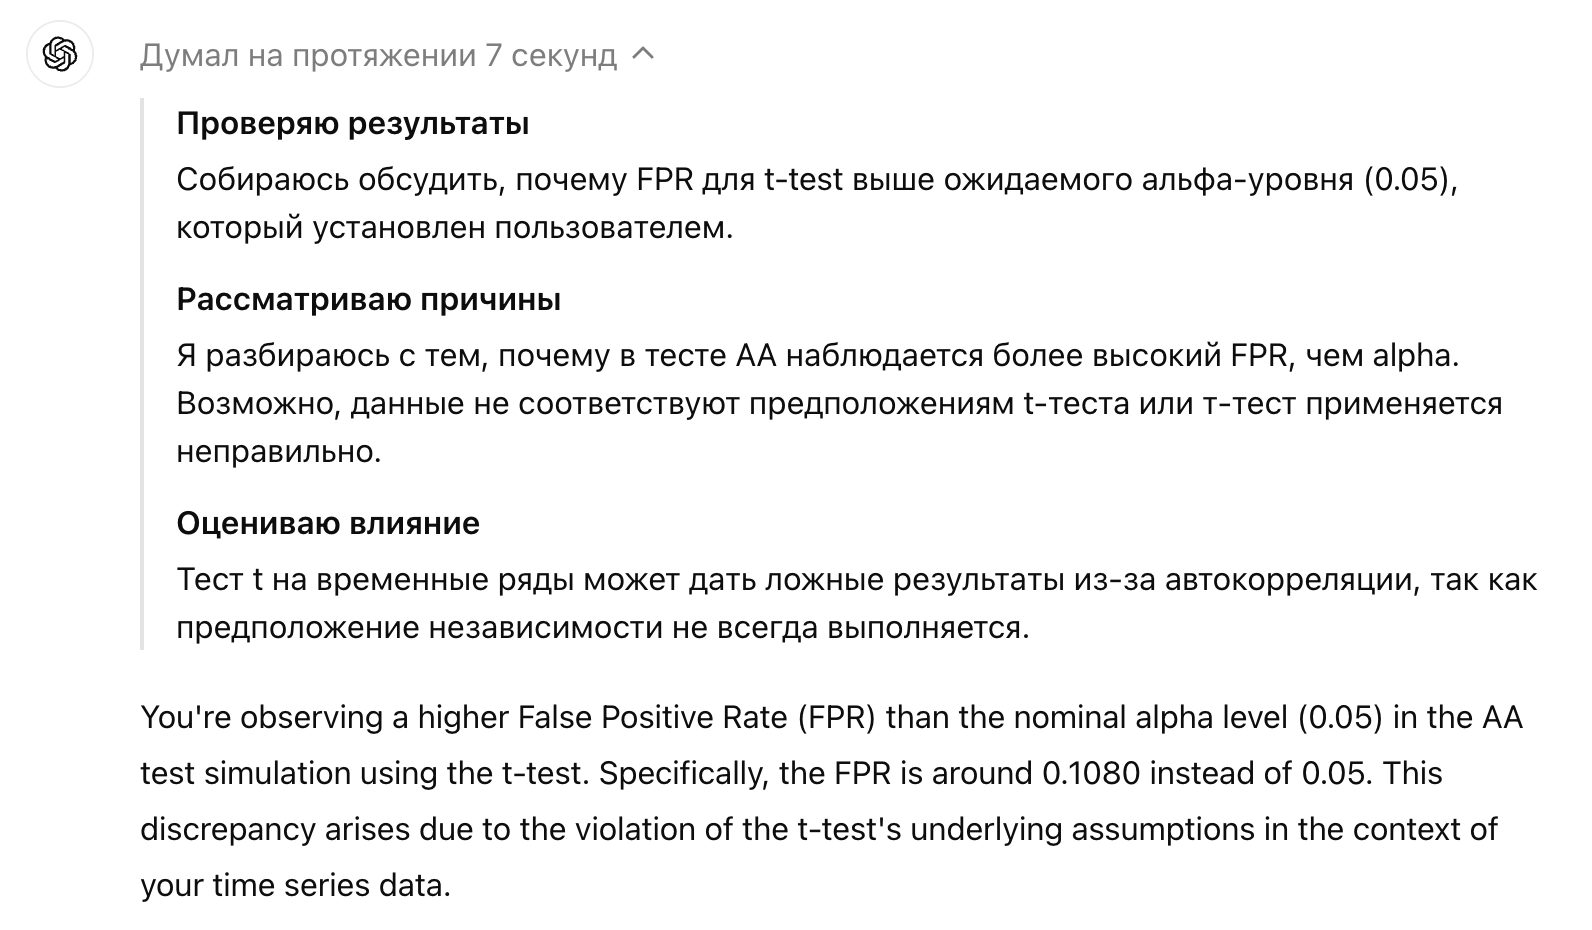

То есть модель коректно распознала причину, и заьем объяснила, как с ней работать.

Пока посмотрим первиую версию кодва, затем приведу новый вариант.

In [ ]:
# Function to perform a single AB test
def perform_ab_test(data, control_units, test_units, effect_size=2, effect_start_date='2022-07-01'):
    data['group'] = data['unit'].apply(
        lambda x: 'control' if x in control_units else 'test'
    )
    # Introduce effect in test group after the effect start date
    effect_mask = (data['date'] >= effect_start_date) & (data['group'] == 'test')
    data.loc[effect_mask, 'metric'] += effect_size
    grouped = data.groupby(['date', 'group'])['metric'].mean().reset_index()
    grouped_pivot = grouped.pivot(index='date', columns='group', values='metric')
    control_metric = grouped_pivot['control']
    test_metric = grouped_pivot['test']
    # Perform t-test
    t_stat, p_value = ttest_ind(control_metric, test_metric)
    return p_value

# Simulate multiple AB tests to estimate Power
num_simulations = 1000
alpha = 0.05
detections = 0

for _ in tqdm(range(num_simulations)):
    # Randomly assign units
    units = np.arange(num_units)
    np.random.shuffle(units)
    control_units = units[:num_units // 2]
    test_units = units[num_units // 2:]

    p_value = perform_ab_test(data.copy(), control_units, test_units)
    if p_value < alpha:
        detections += 1

print(f"Power (t-test): {detections / num_simulations:.4f}")


Power (t-test): 0.7680


In [ ]:
import statsmodels.formula.api as smf

# Function to perform Diff-in-Diff analysis
def perform_diff_in_diff(data, control_units, test_units, effect_size=2, effect_start_date='2022-07-01'):
    data['group'] = data['unit'].apply(
        lambda x: 'control' if x in control_units else 'test'
    )
    # Introduce effect in test group after the effect start date
    effect_mask = (data['date'] >= effect_start_date) & (data['group'] == 'test')
    data.loc[effect_mask, 'metric'] += effect_size
    # Create treatment and post indicators
    data['treatment'] = (data['group'] == 'test').astype(int)
    data['post'] = (data['date'] >= effect_start_date).astype(int)
    # Interaction term
    data['treatment_post'] = data['treatment'] * data['post']
    # Fit Diff-in-Diff model
    model = smf.ols('metric ~ treatment + post + treatment_post', data=data)
    result = model.fit()
    p_value = result.pvalues['treatment_post']
    return p_value

# Simulate multiple Diff-in-Diff tests to estimate Power
num_simulations = 1000
alpha = 0.05
detections = 0

for _ in tqdm(range(num_simulations)):
    # Randomly assign units
    units = np.arange(num_units)
    np.random.shuffle(units)
    control_units = units[:num_units // 2]
    test_units = units[num_units // 2:]

    p_value = perform_diff_in_diff(data.copy(), control_units, test_units)
    if p_value < alpha:
        detections += 1

print(f"Power (Diff-in-Diff): {detections / num_simulations:.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Power (Diff-in-Diff): 1.0000


Мощность в 100% кажется не очень правдоподобной, хотя реализация выглядит корректно. ПОтенциальное объяснение - синтетические данные слишком хорошие, поэтому diff in diff с ними так хорошо справляется.

Вот что говорит ChatGPT:

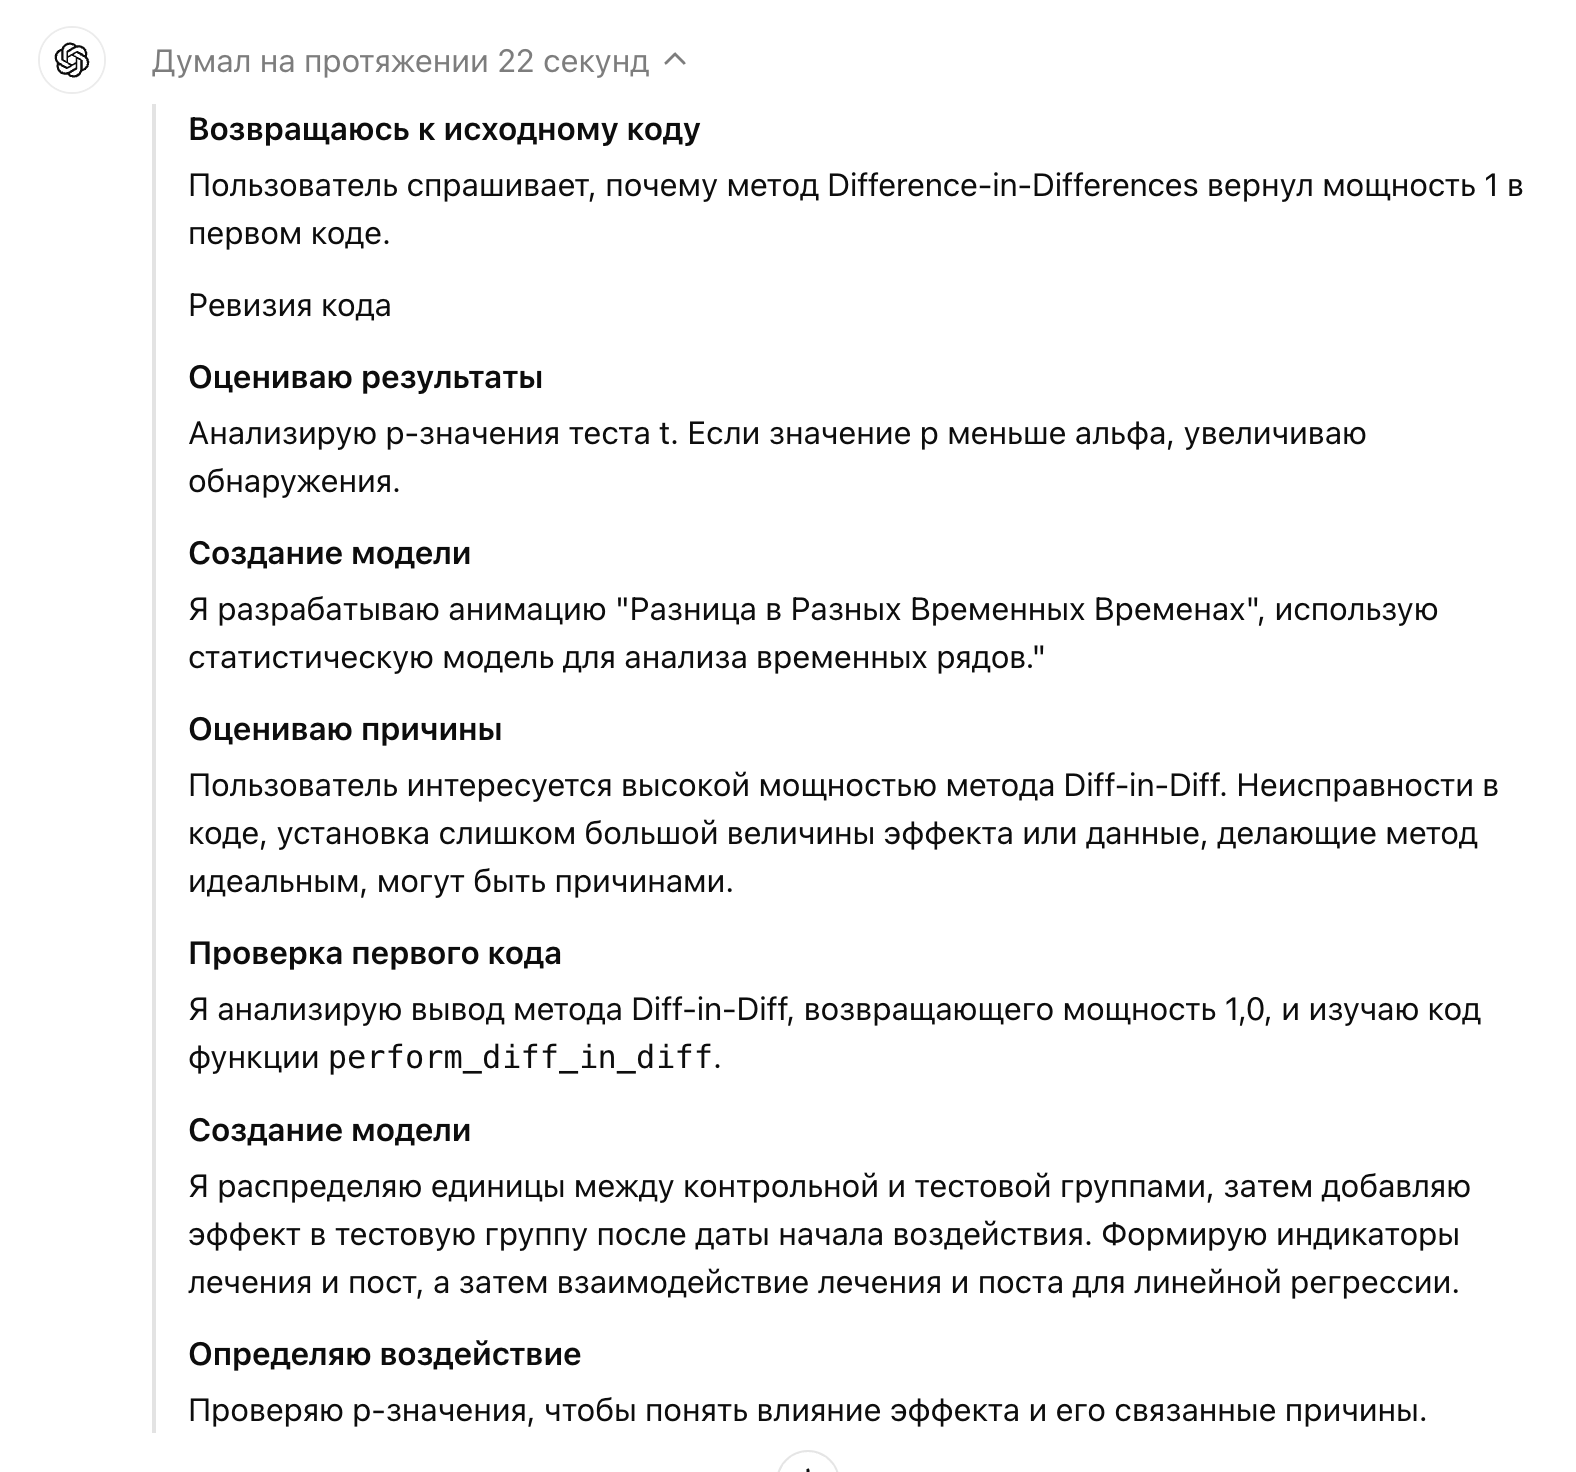

С casual impact так же возникли проблемы с установкой и запуском.

## Версия с исправлениями

Потребовалось несколько промптов , чтобы исправить ошибки в коде, проблемы с испортом библиотек, по-другому сгенерировать данные и заставить это все работать.

In [1]:
#!pip install tfcausalimpact

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from causalimpact import CausalImpact
from tqdm.notebook import tqdm


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate date range
date_range = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
n_days = len(date_range)  # Number of days

# Number of users
num_users = 1000

# Generate user IDs
user_ids = np.arange(num_users)

# Create a DataFrame with all combinations of users and dates
data = pd.DataFrame({
    'date': np.tile(date_range, num_users),
    'user_id': np.repeat(user_ids, n_days)
})

# Generate user-level random effects (user-specific means)
user_effects = np.random.normal(loc=50, scale=5, size=num_users)
data['user_effect'] = data['user_id'].map(dict(zip(user_ids, user_effects)))

# Generate daily random noise (independent across users and dates)
data['metric'] = data['user_effect'] + np.random.normal(loc=0, scale=10, size=len(data))

# Remove unnecessary columns
data = data[['date', 'user_id', 'metric']]

# Preview the data
print(data.head())


        date  user_id     metric
0 2022-01-01        0  66.477125
1 2022-01-02        0  61.729908
2 2022-01-03        0  53.079874
3 2022-01-04        0  46.014203
4 2022-01-05        0  59.465804


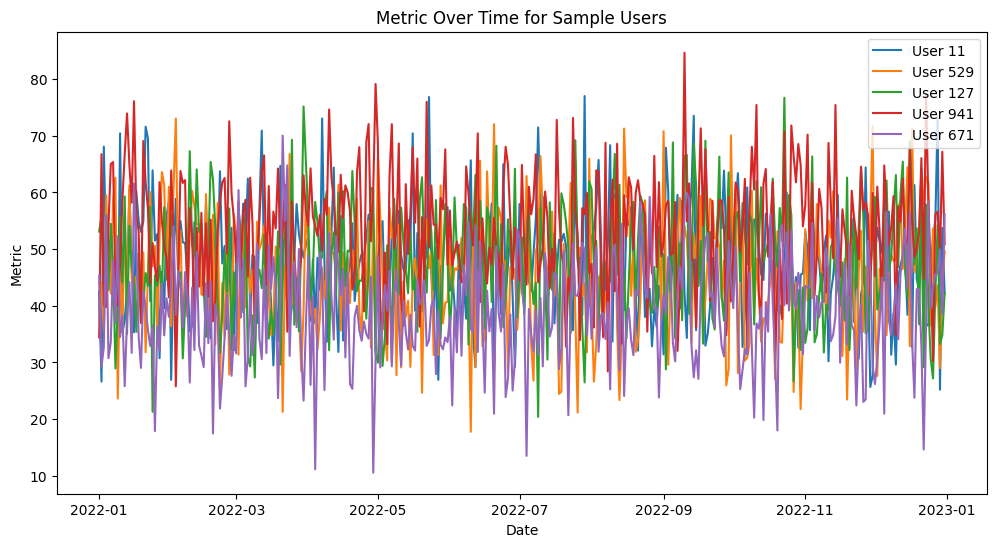

In [3]:
# Sample 5 users for visualization
sample_users = np.random.choice(user_ids, size=5, replace=False)
sample_data = data[data['user_id'].isin(sample_users)]

# Plot time series for the sample users
plt.figure(figsize=(12, 6))
for user_id in sample_users:
    user_data = sample_data[sample_data['user_id'] == user_id]
    plt.plot(user_data['date'], user_data['metric'], label=f'User {user_id}')
plt.title('Metric Over Time for Sample Users')
plt.xlabel('Date')
plt.ylabel('Metric')
plt.legend()
plt.show()


In [9]:
num_simulations = 100  # Number of simulations for t-test and Diff-in-Diff
num_simulations_ci = 100  # Number of simulations for Causal Impact (reduced due to computation time)
alpha = 0.05  # Significance level
effect_size = 1  # Effect size for the AB tests


In [15]:
def perform_aa_test_ttest(data, control_users, test_users):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # Aggregate metric over time for each user
    user_metrics = data.groupby(['user_id', 'group'])['metric'].mean().reset_index()
    control_metric = user_metrics[user_metrics['group'] == 'control']['metric']
    test_metric = user_metrics[user_metrics['group'] == 'test']['metric']
    # Perform t-test
    t_stat, p_value = ttest_ind(control_metric, test_metric, equal_var=True)
    return p_value

# Simulate multiple AA tests to estimate False Positive Rate
false_positives_ttest = 0

for _ in tqdm(range(num_simulations)):
    # Randomly assign users to control and test groups
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_aa_test_ttest(data, control_users, test_users)
    if p_value < alpha:
        false_positives_ttest += 1

print(f"False Positive Rate (t-test): {false_positives_ttest / num_simulations:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

False Positive Rate (t-test): 0.0500


In [10]:
def perform_ab_test_ttest(data, control_users, test_users, effect_size=effect_size):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # Introduce effect in test group
    data.loc[data['group'] == 'test', 'metric'] += effect_size
    # Aggregate metric over time for each user
    user_metrics = data.groupby(['user_id', 'group'])['metric'].mean().reset_index()
    control_metric = user_metrics[user_metrics['group'] == 'control']['metric']
    test_metric = user_metrics[user_metrics['group'] == 'test']['metric']
    # Perform t-test
    t_stat, p_value = ttest_ind(control_metric, test_metric, equal_var=True)
    return p_value

# Simulate multiple AB tests to estimate Power
detections_ttest = 0

for _ in tqdm(range(num_simulations)):
    # Randomly assign users to control and test groups
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_ab_test_ttest(data, control_users, test_users)
    if p_value < alpha:
        detections_ttest += 1

print(f"Power (t-test): {detections_ttest / num_simulations:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Power (t-test): 0.9100


In [33]:
def perform_aa_test_diff_in_diff(data, control_users, test_users):
    data = data.copy()
    time_series = prepare_time_series_data(data, control_users, test_users)
    # Create treatment and post indicators (no effect introduced)
    time_series['treatment'] = (time_series['group'] == 'test').astype(int)
    # Randomly select a date to split pre and post period
    split_date = data['date'].sample(1).values[0]
    time_series['post'] = (time_series['date'] >= split_date).astype(int)
    # Interaction term
    time_series['treatment_post'] = time_series['treatment'] * time_series['post']
    # Fit Diff-in-Diff model with robust standard errors
    model = smf.ols('metric ~ treatment + post + treatment_post', data=time_series)
    result = model.fit(cov_type='HC3')  # Heteroscedasticity-consistent standard errors
    p_value = result.pvalues['treatment_post']
    return p_value

# Prepare function to aggregate data over time by group
def prepare_time_series_data(data, control_users, test_users):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # Aggregate metric over users for each date
    time_series = data.groupby(['date', 'group'])['metric'].mean().reset_index()
    return time_series

# Simulate multiple AA tests to estimate FPR for Diff-in-Diff
false_positives_diff_in_diff = 0

for _ in tqdm(range(num_simulations)):
    # Randomly assign users
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_aa_test_diff_in_diff(data, control_users, test_users)
    if p_value < alpha:
        false_positives_diff_in_diff += 1

print(f"False Positive Rate (Diff-in-Diff): {false_positives_diff_in_diff / num_simulations:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

False Positive Rate (Diff-in-Diff): 0.1400


In [11]:
def perform_ab_test_diff_in_diff(data, control_users, test_users, effect_size=1, effect_start_date='2022-07-01'):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # Introduce varying effect sizes for test users
    effect_mask = (data['date'] >= effect_start_date) & (data['group'] == 'test')
    # Random effect sizes for each test user
    unit_effect_sizes = np.random.normal(effect_size, 0.2, size=len(test_users))
    effect_map = dict(zip(test_users, unit_effect_sizes))
    data['effect_size'] = data['user_id'].map(effect_map).fillna(0)
    # Apply effect
    data.loc[effect_mask, 'metric'] += data.loc[effect_mask, 'effect_size']
    # Prepare time series data
    time_series = data.groupby(['date', 'group'])['metric'].mean().reset_index()
    # Create treatment and post indicators
    time_series['treatment'] = (time_series['group'] == 'test').astype(int)
    time_series['post'] = (time_series['date'] >= effect_start_date).astype(int)
    # Interaction term
    time_series['treatment_post'] = time_series['treatment'] * time_series['post']
    # Fit Diff-in-Diff model with robust standard errors
    model = smf.ols('metric ~ treatment + post + treatment_post', data=time_series)
    result = model.fit(cov_type='HC3')
    p_value = result.pvalues['treatment_post']
    return p_value

# Simulate multiple AB tests to estimate Power for Diff-in-Diff
detections_diff_in_diff = 0

for _ in range(num_simulations):
    # Randomly assign users
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_ab_test_diff_in_diff(data, control_users, test_users)
    if p_value < alpha:
        detections_diff_in_diff += 1

print(f"Power (Diff-in-Diff): {detections_diff_in_diff / num_simulations:.4f}")


Power (Diff-in-Diff): 1.0000


In [16]:
import re
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore')

def extract_p_value(summary_str):
    # Use regular expression to find the line containing the p-value
    match = re.search(r'Posterior tail-area probability p:\s+([0-9.]+)', summary_str)
    if match:
        p_value = float(match.group(1))
        return p_value
    else:
        # If the p-value is not found, return None or raise an error
        return None

def perform_aa_test_causal_impact(data, control_users, test_users):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # No effect introduced

    # Aggregate data
    control_series = data[data['group'] == 'control'].groupby('date')['metric'].mean()
    test_series = data[data['group'] == 'test'].groupby('date')['metric'].mean()

    # Prepare data for Causal Impact
    df_ci = pd.DataFrame({'y': test_series, 'X': control_series})
    df_ci = df_ci.dropna()

    # Randomly select a date to split pre and post period
    split_date = data['date'].sample(1).values[0]
    pre_period = [df_ci.index.min(), pd.to_datetime(split_date) - pd.Timedelta(days=1)]
    post_period = [pd.to_datetime(split_date), df_ci.index.max()]

    # Run Causal Impact analysis
    ci = CausalImpact(df_ci, pre_period, post_period)

    # Extract p-value from summary_data
    res = ci.summary()
    p_value = extract_p_value(res)

    return p_value

# Simulate multiple AA tests to estimate FPR for Causal Impact
false_positives_causal_impact = 0

for _ in range(num_simulations_ci):
    # Randomly assign users
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_aa_test_causal_impact(data, control_users, test_users)
    if p_value < alpha:
        false_positives_causal_impact += 1


print(f"False Positive Rate (Causal Impact): {false_positives_causal_impact / num_simulations_ci:.4f}")


False Positive Rate (Causal Impact): 0.0700


In [13]:
def perform_ab_test_causal_impact(data, control_users, test_users, effect_size=1, effect_start_date='2022-07-01'):
    data = data.copy()
    data['group'] = data['user_id'].apply(
        lambda x: 'control' if x in control_users else 'test'
    )
    # Introduce varying effect sizes for test users
    effect_mask = (data['date'] >= effect_start_date) & (data['group'] == 'test')
    # Random effect sizes for each test user
    unit_effect_sizes = np.random.normal(effect_size, 0.2, size=len(test_users))
    effect_map = dict(zip(test_users, unit_effect_sizes))
    data['effect_size'] = data['user_id'].map(effect_map).fillna(0)
    # Apply effect
    data.loc[effect_mask, 'metric'] += data.loc[effect_mask, 'effect_size']

    # Aggregate data
    control_series = data[data['group'] == 'control'].groupby('date')['metric'].mean()
    test_series = data[data['group'] == 'test'].groupby('date')['metric'].mean()

    # Prepare data for Causal Impact
    df_ci = pd.DataFrame({'y': test_series, 'X': control_series})
    df_ci = df_ci.dropna()

    pre_period = [df_ci.index.min(), pd.to_datetime(effect_start_date) - pd.Timedelta(days=1)]
    post_period = [pd.to_datetime(effect_start_date), df_ci.index.max()]

    # Run Causal Impact analysis
    ci = CausalImpact(df_ci, pre_period, post_period)

    # Extract p-value from summary_data
    res = ci.summary()
    p_value = extract_p_value(res)

    return p_value

# Simulate multiple AB tests to estimate Power for Causal Impact
detections_causal_impact = 0

for _ in tqdm(range(num_simulations_ci)):
    # Randomly assign users
    users = np.random.permutation(user_ids)
    split_point = len(users) // 2
    control_users = users[:split_point]
    test_users = users[split_point:]

    p_value = perform_ab_test_causal_impact(data, control_users, test_users)
    if p_value < alpha:
        detections_causal_impact += 1

print(f"Power (Causal Impact): {detections_causal_impact / num_simulations_ci:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Power (Causal Impact): 1.0000


## Небольшой вывод

В целом, заметно, что модель стала умнее, выдает гораздо более длинные и сложные ответы. При этом суть работы не сильно поменялась, она все так же совершает ошибки, и требует дебагов. При этом, весь этот код получилось сгенерировать примерно за час, сам бы я потратил кратно больше времени. Использовать определено стоит, но в разумных пределах и понимая те задачи, с которыми модель хорошо справляется.

А по поводу сравнения t-test с diff-in-diff и casual impact - видно, что FPR у квази-экспериментов выше, но выше и мощность. По поводу корректности выводов по мощности есть сомнения, и вероятно здесь играет роль специфика сгенерированных данных. Для чистоты эксперимента, я бы проверил эти методы на реальных данных.

